# Installing libraries

In [1]:
!pip install transformers datasets evaluate accelerate peft trl bitsandbytes
!pip install nvidia-ml-py3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 22.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-

# Load the dataset

In [2]:
import re
import os
import pandas as pd
import torch
from transformers import RobertaModel, RobertaTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding, RobertaForSequenceClassification
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import load_dataset, Dataset, ClassLabel
import pickle

dataset = load_dataset('ag_news', split='train')

def clean_escape_sequences(example):
    text = example['text']
    #brackets
    text = re.sub(r'\(.*?\)', '', text)
    brackets = re.findall(r'\((.*?)\)', text)
 
    # unique_bracket_contents.update(brackets)
    text = re.sub(r'\b\S+\.com\b', '', text)

    # Replace common escape sequences with space
    text = re.sub(r'[\b\f\r\t]', ' ', text)  # replace \b, \f, \r, \t with space
    text = text.replace('\\', ' ')  # remove backslashes used in escapes

    # Replace ALL floats and integers with 10
    text = re.sub(r'\b\d*\.\d+\b', '9', text)  # floats
    text = re.sub(r'\b\d+\b', '9', text)       # integers
    text = re.sub(r'\s+', ' ', text)  # normalize multiple spaces

    return {'text': text.strip()}

# Apply the cleaning function
cleaned_dataset = dataset.map(clean_escape_sequences, load_from_cache_file=False)

base_model = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(base_model)

def preprocess(examples):
    tokenized = tokenizer(examples['text'], truncation=True, padding=True, max_length=128)
    return tokenized

tokenized_dataset = cleaned_dataset.map(preprocess, batched=True,  remove_columns=["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

# Extract the number of classess and their names
num_labels = dataset.features['label'].num_classes
class_names = dataset.features["label"].names
print(f"number of labels: {num_labels}")
print(f"the labels: {class_names}")

# Create an id2label mapping
# We will need this for our classifier.
id2label = {i: label for i, label in enumerate(class_names)}

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

2025-04-22 00:08:30.128508: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745280510.329061      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745280510.383242      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

number of labels: 4
the labels: ['World', 'Sports', 'Business', 'Sci/Tech']


## Understand the distribution of token lengths

Mean: 51.49, Std Dev: 16.21


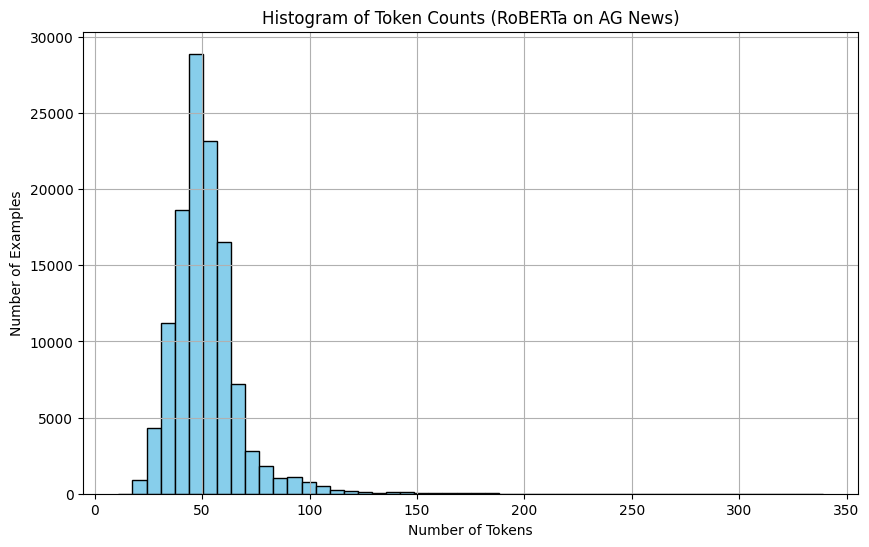

Ideal token length cutoff for 99.5% coverage: 128


,Token Length,Count,Cumulative Count,Cumulative Proportion
0,11,1,1,0.000008
1,12,1,2,0.000017
2,13,2,4,0.000033
3,16,1,5,0.000042
4,17,1,6,0.000050


In [5]:
import numpy as np
import matplotlib.pyplot as plt

def count_tokens(example):
    tokens = tokenizer(example["text"], truncation=False)["input_ids"]
    return {"num_tokens": len(tokens)}

# Apply function
dataset_fa = cleaned_dataset.map(count_tokens)

# Extract token counts
token_counts = dataset_fa["num_tokens"]

# Compute mean and std
mean_tokens = np.mean(token_counts)
std_tokens = np.std(token_counts)
print(f"Mean: {mean_tokens:.2f}, Std Dev: {std_tokens:.2f}")

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(token_counts, bins=50, color='skyblue', edgecolor='black')
plt.title("Histogram of Token Counts (RoBERTa on AG News)")
plt.xlabel("Number of Tokens")
plt.ylabel("Number of Examples")
plt.grid(True)
plt.show()

token_lengths, counts = np.unique(token_counts, return_counts=True)
cumulative_counts = np.cumsum(counts)
total = cumulative_counts[-1]
cumulative_proportions = cumulative_counts / total

# Create DataFrame
df = pd.DataFrame({
    "Token Length": token_lengths,
    "Count": counts,
    "Cumulative Count": cumulative_counts,
    "Cumulative Proportion": cumulative_proportions
})

# Suggest cutoff at 95%
val = 0.995
cutoff = token_lengths[np.searchsorted(cumulative_proportions, val)]
print('Ideal token length cutoff for {}% coverage: {}'.format(100*val, cutoff))

from IPython.display import display, HTML
#display(HTML(df.to_html(max_rows=None, max_cols=None)))

df.head()

# Split dataset

In [6]:
# # Split the original training set
split_datasets = tokenized_dataset.train_test_split(test_size=640, seed=42)
train_dataset = split_datasets['train']
eval_dataset = split_datasets['test']

# Set LoRA parameters

In [8]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import torch.nn as nn
import math

model = RobertaForSequenceClassification.from_pretrained(
    base_model,
    id2label=id2label)

def apply_layerwise_lora(model, layer_config_map):
    """
    model: the base transformer model (e.g., RoBERTa)
    layer_config_map: dict with keys as layer numbers and values as LoraConfig
    """
    # Iterate over each layer and create individual LoraConfig
    for layer_num, lora_cfg in layer_config_map.items():
        # Patch the specific layer by updating the LoraConfig with the layer's name
        lora_cfg.target_modules = [f"encoder.layer.{layer_num}.attention.self.query"]

        # Wrap the model with the LoraConfig
        model = get_peft_model(model, lora_cfg)

    model.print_trainable_parameters()
    return model

# Define a LoraConfig per layer with varying r and alpha
layer_config_map = {
    i: LoraConfig(
        r=8 * (2 ** (i // 4)),
        lora_alpha=16 * (2 ** ((i+1) // 4)),
        target_modules=['Query'],
        task_type="SEQ_CLS"
    )
    for i in range(12)
}

# Apply layer-wise LoRA
peft_model = apply_layerwise_lora(model, layer_config_map)

# Print final trainable parameters
print("Trainable parameters:")
for name, param in peft_model.named_parameters():
    if param.requires_grad:
        print(name)

print("\nPEFT Model")
peft_model.print_trainable_parameters()


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 937,732 || all params: 125,586,440 || trainable%: 0.7467
Trainable parameters:
base_model.model.base_model.model.base_model.model.base_model.model.base_model.model.base_model.model.base_model.model.base_model.model.base_model.model.base_model.model.base_model.model.base_model.model.roberta.encoder.layer.0.attention.self.query.lora_A.default.weight
base_model.model.base_model.model.base_model.model.base_model.model.base_model.model.base_model.model.base_model.model.base_model.model.base_model.model.base_model.model.base_model.model.base_model.model.roberta.encoder.layer.0.attention.self.query.lora_B.default.weight
base_model.model.base_model.model.base_model.model.base_model.model.base_model.model.base_model.model.base_model.model.base_model.model.base_model.model.base_model.model.base_model.model.base_model.model.roberta.encoder.layer.1.attention.self.query.lora_A.default.weight
base_model.model.base_model.model.base_model.model.base_model.model.base_model.model.base_

## Define trainer and set training parameters


In [11]:
from sklearn.metrics import accuracy_score
from transformers import TrainingArguments, Trainer

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        # Safely remove num_items_in_batch and other unexpected kwargs
        inputs = {k: v for k, v in inputs.items() if k != "num_items_in_batch"}
        
        outputs = model(**inputs)
        loss = outputs.loss
        return (loss, outputs) if return_outputs else loss


# Metrics for evaluation
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    return {'accuracy': accuracy}

# Training args
output_dir = "results"
training_args = TrainingArguments(
    output_dir=output_dir,
    report_to="none",
    eval_strategy='steps',
    logging_steps=100,
    warmup_ratio=0.06,
    learning_rate=3e-6,
    weight_decay=0.01,
    num_train_epochs=4,
    save_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    label_names=["labels"],
    use_cpu=False,
    dataloader_num_workers=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    optim="adamw_torch",
    gradient_checkpointing=False,
    gradient_checkpointing_kwargs={'use_reentrant': True},
)

# Updated to use CustomTrainer
def get_trainer(model):
    return CustomTrainer(
        model=model,
        args=training_args,
        compute_metrics=compute_metrics,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        data_collator=data_collator,
    )

# Train the model
peft_lora_finetuning_trainer = get_trainer(peft_model)
result = peft_lora_finetuning_trainer.train()

Step,Training Loss,Validation Loss,Accuracy
100,1.352700,1.353972,0.298438
200,1.352800,1.353335,0.307812
300,1.350100,1.352243,0.321875
400,1.349600,1.350596,0.389062
500,1.346100,1.348508,0.421875
600,1.345000,1.345654,0.512500
700,1.343100,1.341944,0.592187
800,1.339800,1.338048,0.631250
900,1.335500,1.332531,0.707812
1000,1.330200,1.326586,0.760938


# Function for inference on custom input

In [12]:
#base_model = RobertaForSequenceClassification.from_pretrained('roberta-base', id2label=id2label)
#loaded_model = PeftModel.from_pretrained(base_model, "/kaggle/working/results/checkpoint-4000")
#loaded_model = loaded_model.to('cuda:0')

def classify(model, tokenizer, text):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = tokenizer(text, truncation=True, padding=True, return_tensors="pt").to(device)
    output = model(**inputs)

    prediction = output.logits.argmax(dim=-1).item()

    print(f'\n Class: {prediction}, Label: {id2label[prediction]}, Text: {text}')
    return id2label[prediction]

In [13]:
classify( peft_model, tokenizer, "Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...")


 Class: 1, Label: Sports, Text: Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...


'Sports'

In [14]:
classify( peft_model, tokenizer, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.")


 Class: 2, Label: Business, Text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindlinand of ultra-cynics, are seeing green again.


'Business'

# Run Inference on eval_dataset

In [15]:
from torch.utils.data import DataLoader
import evaluate
from tqdm import tqdm

def evaluate_model(inference_model, dataset, labelled=True, batch_size=8, data_collator=None):
    """
    Evaluate a PEFT model on a dataset.

    Args:
        inference_model: The model to evaluate.
        dataset: The dataset (Hugging Face Dataset) to run inference on.
        labelled (bool): If True, the dataset includes labels and metrics will be computed.
                         If False, only predictions will be returned.
        batch_size (int): Batch size for inference.
        data_collator: Function to collate batches. If None, the default collate_fn is used.

    Returns:
        If labelled is True, returns a tuple (metrics, predictions)
        If labelled is False, returns the predictions.
    """
    # Create the DataLoader
    eval_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inference_model.to(device)
    inference_model.eval()

    all_predictions = []
    if labelled:
        metric = evaluate.load('accuracy')

    # Loop over the DataLoader
    for batch in tqdm(eval_dataloader):
        # Move each tensor in the batch to the device
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = inference_model(**batch)
        predictions = outputs.logits.argmax(dim=-1)
        all_predictions.append(predictions.cpu())

        if labelled:
            # Expecting that labels are provided under the "labels" key.
            references = batch["labels"]
            metric.add_batch(
                predictions=predictions.cpu().numpy(),
                references=references.cpu().numpy()
            )

    # Concatenate predictions from all batches
    all_predictions = torch.cat(all_predictions, dim=0)

    if labelled:
        eval_metric = metric.compute()
        print("Evaluation Metric:", eval_metric)
        return eval_metric, all_predictions
    else:
        return all_predictions

In [17]:
# Check evaluation accuracy
_, _ = evaluate_model(peft_model, eval_dataset, True, 8, data_collator)

100%|██████████| 80/80 [00:02<00:00, 28.71it/s]

Evaluation Metric: {'accuracy': 0.9078125}


# Run Inference on unlabelled dataset

In [18]:
#Load your unlabelled data
unlabelled_dataset = pd.read_pickle("/kaggle/input/deep-learning-spring-2025-project-2/test_unlabelled.pkl")
test_dataset = unlabelled_dataset.map(preprocess, batched=True, remove_columns=["text"])
unlabelled_dataset

# Run inference and save predictions
preds = evaluate_model(peft_model, test_dataset, False, 8, data_collator)
df_output = pd.DataFrame({
    'ID': range(len(preds)),
    'Label': preds.numpy()  # or preds.tolist()
})
df_output.to_csv(os.path.join(output_dir,"inference_output.csv"), index=False)
print("Inference complete. Predictions saved to inference_output.csv")

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

100%|██████████| 1000/1000 [00:33<00:00, 29.70it/s]

Inference complete. Predictions saved to inference_output.csv


# Generate loss and accuracy plots

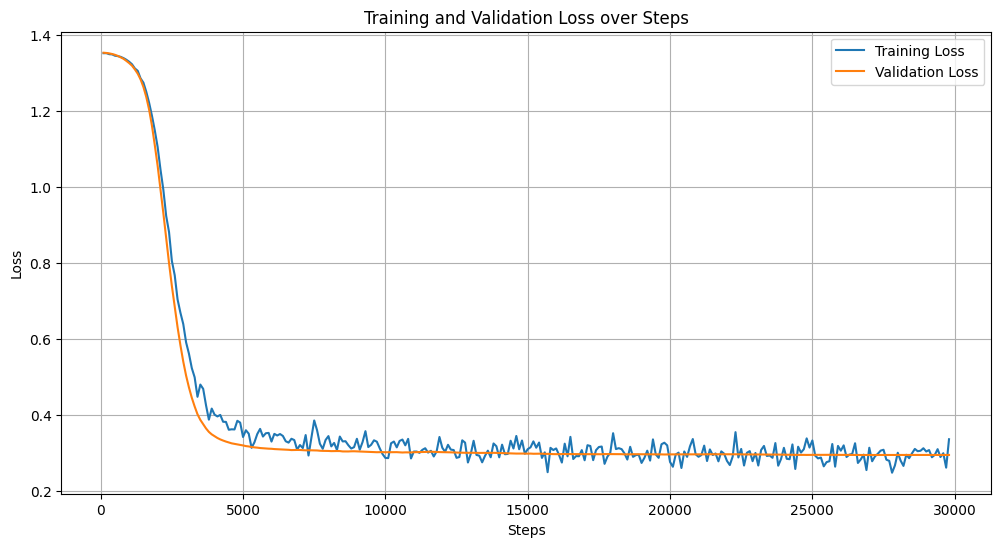

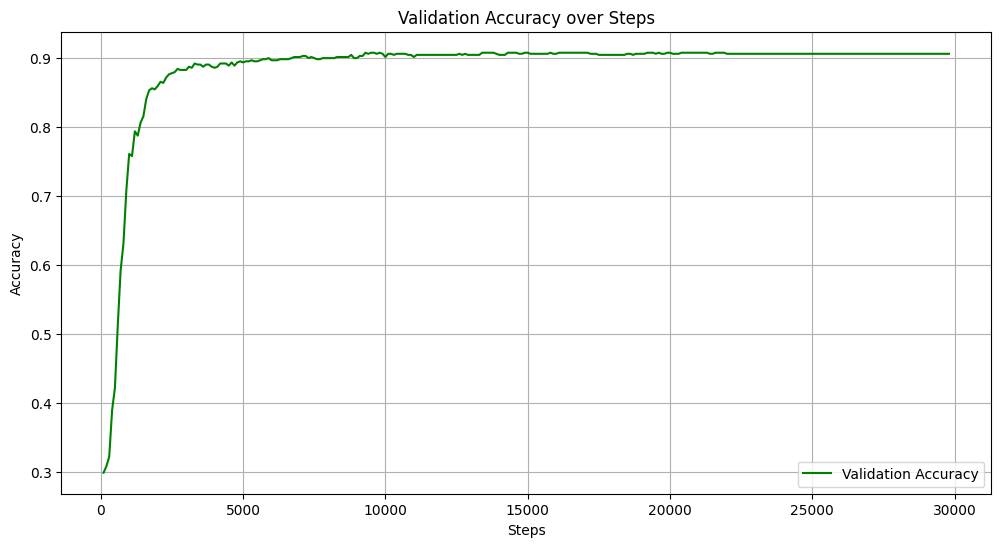

Plots generated.


In [20]:
import matplotlib.pyplot as plt

def plot_trainer_logs(trainer, show_accuracy=True):
    """
    Plot the logs from Huggingface Trainer after training.
    
    Args:
        trainer: A Huggingface Trainer object after .train()
        show_accuracy (bool): Whether to plot evaluation accuracy if available.
    """
    logs = trainer.state.log_history

    steps = []
    train_losses = []
    eval_losses = []
    eval_accuracies = []

    for log in logs:
        if 'loss' in log and 'step' in log:
            steps.append(log['step'])
            train_losses.append(log['loss'])
        if 'eval_loss' in log and 'step' in log:
            eval_losses.append((log['step'], log['eval_loss']))
        if 'eval_accuracy' in log and 'step' in log:
            eval_accuracies.append((log['step'], log['eval_accuracy']))

    # Unpack evaluation data
    eval_steps, eval_loss_values = zip(*eval_losses) if eval_losses else ([], [])
    eval_acc_steps, eval_acc_values = zip(*eval_accuracies) if eval_accuracies else ([], [])

    # Plot Training Loss
    plt.figure(figsize=(12, 6))
    plt.plot(steps, train_losses, label='Training Loss')
    if eval_losses:
        plt.plot(eval_steps, eval_loss_values, label='Validation Loss')
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss over Steps")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Evaluation Accuracy (optional)
    if show_accuracy and eval_accuracies:
        plt.figure(figsize=(12, 6))
        plt.plot(eval_acc_steps, eval_acc_values, label='Validation Accuracy', color='green')
        plt.xlabel("Steps")
        plt.ylabel("Accuracy")
        plt.title("Validation Accuracy over Steps")
        plt.legend()
        plt.grid(True)
        plt.show()

    print("Plots generated.")

plot_trainer_logs(peft_lora_finetuning_trainer)